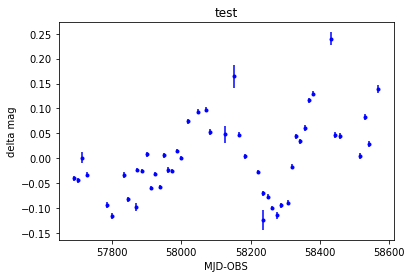

In [41]:
#import os
#os.environ["MKL_THREADING_LAYER"]="GNU"

# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.tensor import fft
import theano.tensor.signal.conv

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_ref1[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [42]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_ref1[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')

xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,(1,2))
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)

Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],(1,2))
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,(1,2))

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_ref1[maskK], dtype=float)

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK),axis=None)
Y_tot=np.reshape(Y_tot,(len(Y_tot),1))

#time delay array
ntau=49
tau=np.linspace(1.0,100.0,ntau)
tau=np.reshape(tau,(1,1,ntau,1))

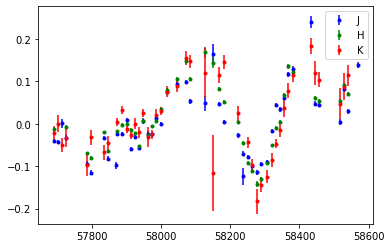

In [3]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='g.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='r.',label='K')
plt.legend()

In [9]:
with pm.Model() as convmodel:
    
    #define driving function as Gaussian Process
    #find way to use g band as first guess of value 
    ℓ = pm.Normal('ℓ', mu=75.0, sigma=25.0)#pm.Uniform('ℓ', lower=1.0, upper=2.0*70.0)#pm.Bound(pm.Normal, lower=1.2574, upper=3.0*50.0*np.sqrt(2.0))('ℓ', mu=70.0, sigma=35.0)#timescale of variation for the driving function
    η = pm.Uniform('η', lower=0.0, upper=1.0)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#using same cov as light curve interpolation
    #const_func = pm.gp.mean.Constant(tt.mean(yJ))#long term mean. Should it be zero or the g-band value?
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_tot)#has all time values for all bands, testval is for g-band diffmag values?
    f = f.reshape((1,1,len(X_tot),1))
    #print(len(f.tag.test_value[0,0,:,0]))
    #print(f.tag.test_value)
    
    
    #Define priors
    
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.Uniform('sigma_DT', lower=tt.log(1.1), upper=tt.log(50.0))#needs a source for scale
    m_DT=pm.Uniform('m_DT', lower=10.0, upper=150.0)#we expect serveral tens to hundreds of days
    theta_DT=pm.Uniform('theta_DT', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later when simple model is staple
    
    #Accretion Disk paramters
    Jsigma_AD=pm.Uniform('Jsigma_AD', lower=tt.log(1.1), upper=tt.log(50.0))#needs a source for scale
    Jm_AD=pm.Uniform('Jm_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT 
    Jtheta_AD=pm.Normal('Jtheta_AD',mu=0,sigma=25.0)#pm.Uniform('Jtheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
   
    Hsigma_AD=pm.Uniform('Hsigma_AD', lower=tt.log(1.1), upper=tt.log(50.0))#needs a source for scale
    Hm_AD=pm.Uniform('Hm_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT
    Htheta_AD=pm.Normal('Htheta_AD',mu=0,sigma=25.0)#pm.Uniform('Htheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
    
    Ksigma_AD=pm.Uniform('Ksigma_AD', lower=tt.log(1.1), upper=tt.log(50.0))#needs a source for scale
    Km_AD=pm.Uniform('Km_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT
    Ktheta_AD=pm.Normal('Ktheta_AD',mu=0,sigma=25.0)#pm.Uniform('Ktheta_AD', lower=-np.max(tau)/1.2, upper=np.max(tau)/1.2)#add later 
    
    #BB and power law parameters
    T=pm.Bound(pm.Normal, lower=1000.0, upper=2000.0)('T', mu=1400.0, sigma=100.0)#taken from nature letter
    K_0=pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Uniform('index', lower=0.0, upper=3.0)#sign depends on diffmag definition change to -2 to -1 for final?

    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm NEED DATASHEET
    Jwav=1250.0
    Hwav=1625.0
    Kwav=2150.0
    #Sloan filters for ROSS2 in nm
    #gwav=475.4
    #rwav= 620.4
    #iwav=769.8
    #zwav=966.5
    

    #Define constants 
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*T)
    JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Dusty Torus transfer equation for H band
    Hb = h*c/(1e-9*Hwav*k*T)
    HBB = (1.0/( Hwav**5 * (tt.exp(Hb) - 1.0) ))/BB_max
    HPsi_DT = HBB*lognorm_DT
    
    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*Kwav*k*T)
    KBB = (1.0/( Kwav**5 * (tt.exp(Kb) - 1.0) ))/BB_max
    KPsi_DT = KBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((tt.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = Jpowr*Jlognorm_AD
    
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0*(Hwav/wav_0)**(index)    
    Hexp_AD = -((tt.log((tau-Htheta_AD)/Hm_AD))**2/(2*Hsigma_AD**2))
    Hfront_AD = 1.0/((tau-Htheta_AD)*Hsigma_AD*np.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*tt.exp(Hexp_AD)
    Hlognorm_AD = tt.switch(tt.isnan(Hlognorm_AD), 0.0, Hlognorm_AD)
    HPsi_AD = Hpowr*Hlognorm_AD
    
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(Kwav/wav_0)**(index)    
    Kexp_AD = -((tt.log((tau-Ktheta_AD)/Km_AD))**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*np.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    Klognorm_AD = tt.switch(tt.isnan(Klognorm_AD), 0.0, Klognorm_AD)
    KPsi_AD = Kpowr*Klognorm_AD
    
    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Htransfer = HPsi_DT + HPsi_AD
    Ktransfer = KPsi_DT + KPsi_AD
    
    #The convolutions
    #filter needs to be odd so tau is odd
    Jconvol=theano.tensor.nnet.conv2d(f[:,:,0:len(xJ),:],Jtransfer,border_mode='half')
    Hconvol=theano.tensor.nnet.conv2d(f[:,:,len(xJ):len(xJ)+len(xH),:],Htransfer,border_mode='half')
    Kconvol=theano.tensor.nnet.conv2d(f[:,:,len(xJ)+len(xH):len(xJ)+len(xH)+len(xK),:],Ktransfer,border_mode='half')
    #print(Hconvol.tag.test_value)
    #Define likelihoods
    #k = pm.Uniform('k', lower=1.0, upper=10.0)#Noise boost factor 
    Jlikelihood = pm.Normal('yJ', mu=Jconvol[0,0,:,0], sigma=yJerr, observed=yJ)
    Hlikelihood = pm.Normal('yH', mu=Hconvol[0,0,:,0], sigma=yHerr, observed=yH)
    Klikelihood = pm.Normal('yK', mu=Kconvol[0,0,:,0], sigma=yKerr, observed=yK)
    #the shape of mu and observed needs to be the same 
    
    tracetransfer = pm.sample(4000,tune=1000,init='advi+adapt_diag',chains=2,cores=8)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
  0%|          | 0/200000 [00:00<?, ?it/s]/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Average Loss = 1,475.9:  57%|█████▋    | 114682/200000 [07:29<05:34, 254.99it/s] 
Convergence achieved at 114700
Interrupted at 114,699 [57%]: Average Loss = 14,963
/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a differ

In [10]:
names=['index', 'K_0','T', 'Ktheta_AD', 'Km_AD', 'Ksigma_AD', 'Htheta_AD', 'Hm_AD', 'Hsigma_AD', 'Jtheta_AD', 'Jm_AD', 'Jsigma_AD', 'theta_DT', 'm_DT', 'sigma_DT', 'η', 'ℓ']
# display the total number and percentage of divergent
divergent = tracetransfer['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = (divergent.nonzero()[0].size / (2*len(tracetransfer))) * 100
print('Percentage of Divergent %.1f' % divperc)

Number of Divergent 1641
Percentage of Divergent 20.5


In [11]:
from collections import defaultdict
divergent_point = defaultdict(list)

chain_warn = tracetransfer.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in convmodel.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])

for RV in convmodel.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])


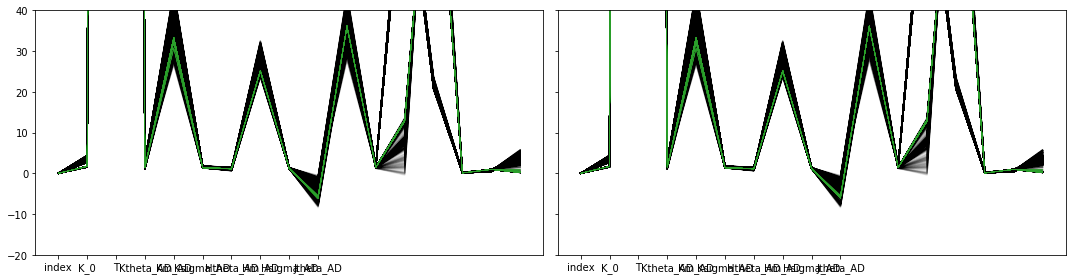

In [12]:
tracedf = pm.trace_to_dataframe(tracetransfer)
plotorder = names
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
divsp = np.hstack([divergent_point['Km_AD_interval__'][:,None],
                  ])

ax[1].plot(divsp.T, 'C3', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
plt.tight_layout();

In [13]:
pm.summary(tracetransfer,names).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
index,0.03,0.02,0.00,0.07,0.00,0.00,41.0,41.0,33.0,29.0,1.15
K_0,2.46,0.85,1.56,3.69,0.59,0.49,2.0,2.0,2.0,11.0,3.01
T,1785.80,15.73,1753.36,1810.05,8.36,6.51,4.0,4.0,3.0,17.0,1.93
Ktheta_AD,2.10,0.65,1.24,2.97,0.46,0.38,2.0,2.0,3.0,11.0,1.92
Km_AD,33.73,3.79,27.78,42.86,2.23,1.77,3.0,3.0,3.0,11.0,1.79
Ksigma_AD,1.55,0.16,1.36,1.82,0.11,0.09,2.0,2.0,3.0,16.0,1.92
Htheta_AD,1.11,0.15,0.81,1.44,0.06,0.05,6.0,6.0,6.0,12.0,1.25
Hm_AD,26.66,2.10,24.32,31.51,1.36,1.11,2.0,2.0,3.0,12.0,2.07
Hsigma_AD,1.29,0.07,1.20,1.43,0.05,0.04,2.0,2.0,3.0,11.0,2.00
Jtheta_AD,-3.85,1.76,-6.09,-1.12,1.04,0.82,3.0,3.0,4.0,18.0,1.58


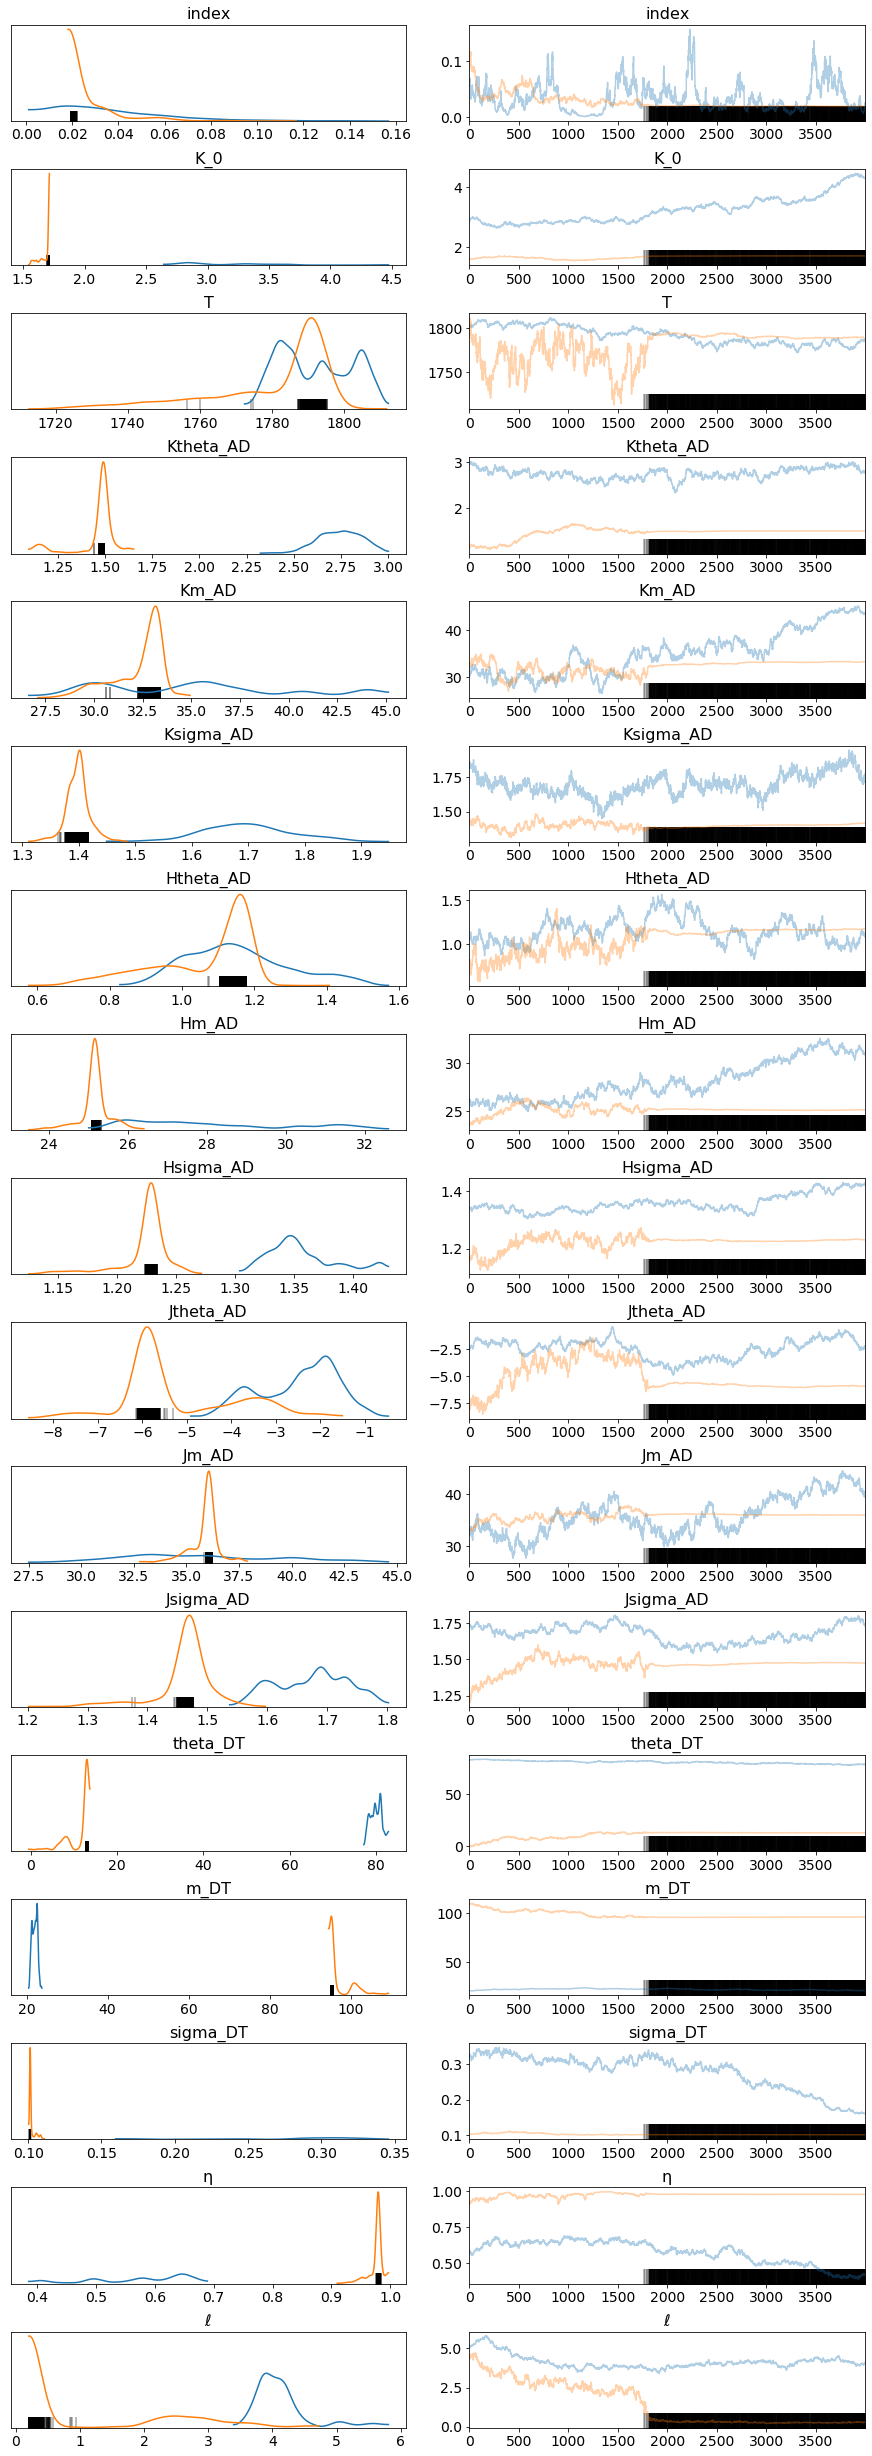

In [14]:
pm.traceplot(tracetransfer, var_names=names);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f89b1665610>,
      dtype=object)

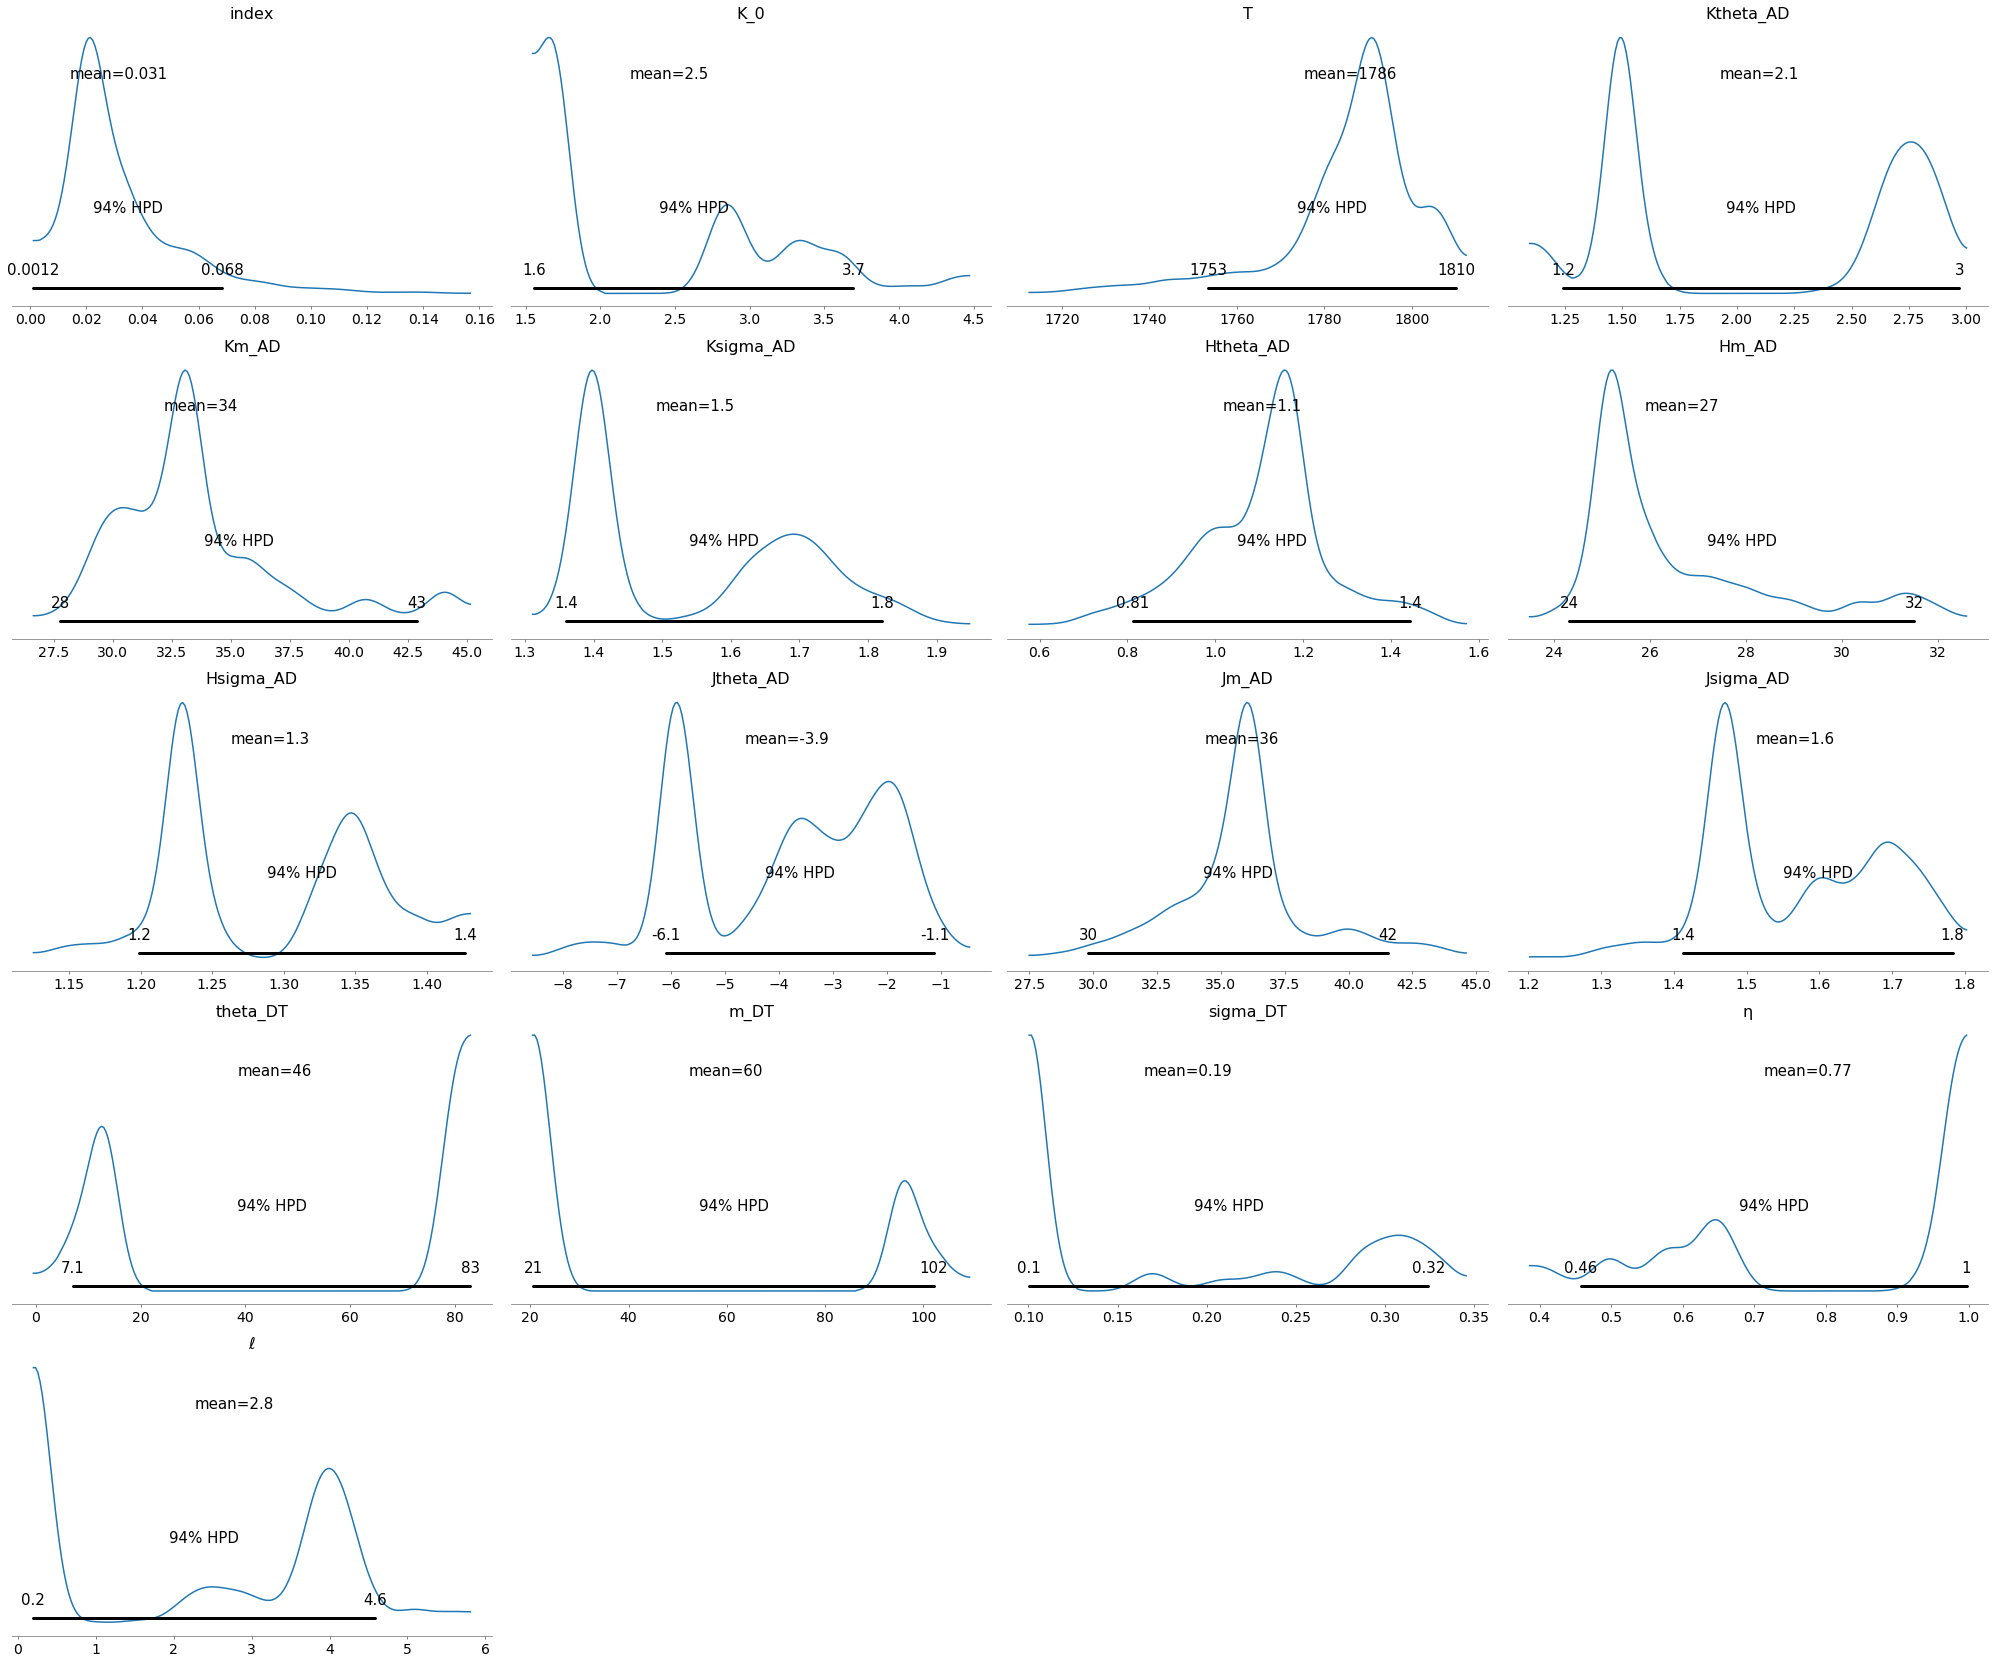

In [15]:
pm.plot_posterior(tracetransfer,names)

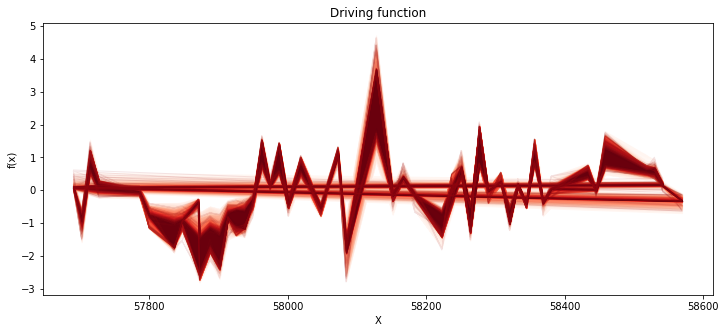

In [20]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, tracetransfer["f"], X_tot);

# plot the data and the true latent function
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("f(x)");
plt.title("Driving function");

In [30]:
n_new = 100
X_new = X_tot#np.linspace(min(X_tot), max(X_tot), n_new)

# add the GP conditional to the model, given the new X values
with convmodel:
    f_tot = gp.conditional("f_tot", X_new)

# Sample from the GP conditional distribution
with convmodel:
    pred_samples = pm.sample_posterior_predictive(tracetransfer, vars=[f_tot], samples=10000)

100%|██████████| 10000/10000 [02:12<00:00, 75.60it/s]


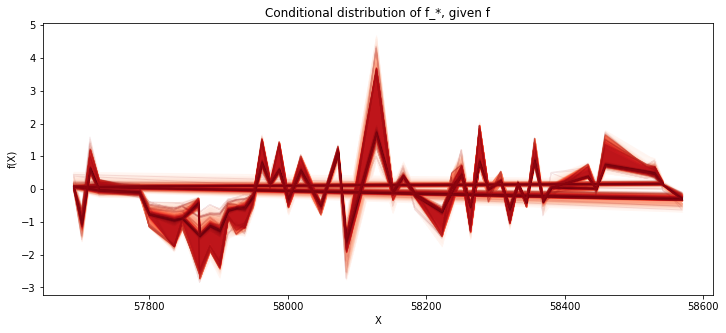

In [31]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_tot"], X_new);
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("f(X)");
plt.title("Conditional distribution of f_*, given f");

0.27485730500782113


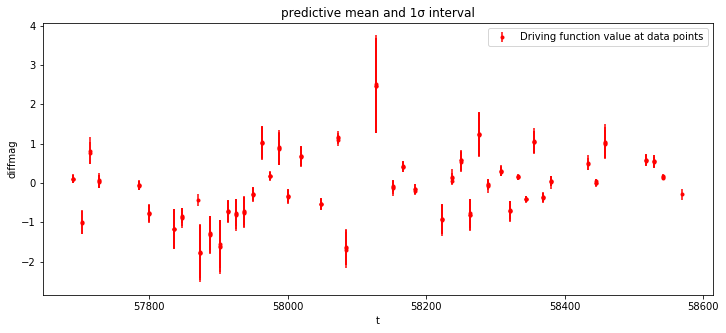

In [58]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_tot"][:,i])
    sd[i] = np.std(pred_samples["f_tot"][:,i])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
#plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
#plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
#plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)
plt.errorbar(X_tot,mu,sd,fmt='r.',label='Driving function value at data points')

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();
print(np.mean(sd))

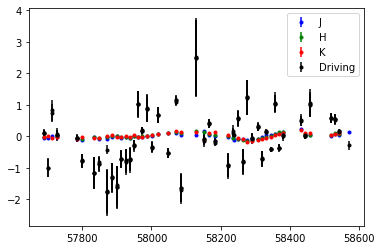

In [56]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='g.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='r.',label='K')
plt.errorbar(X_tot,mu,sd,fmt='k.',label='Driving')
plt.legend()

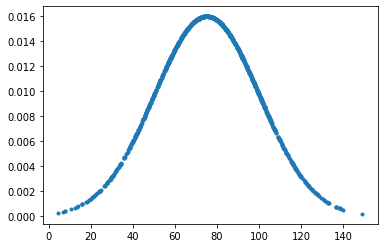

In [8]:
import numpy as np
import matplotlib.pyplot as plt

mu,sigma,n = 75.0,25.,1000

def normal(x,mu,sigma):
    return ( 2.*np.pi*sigma**2. )**-.5 * np.exp( -.5 * (x-mu)**2. / sigma**2. )

x = np.random.normal(mu,sigma,n) 
y = normal(x,mu,sigma) 


plt.plot(x,y,'.')
#plt.plot(np.log(x),np.log(y),'*')

# Specify simple model to save time 

In [ ]:
with pm.Model() as simpleconvmodel:
    
    #define driving function as Gaussian Process
    #find way to use g band as first guess of value 
    ℓ = pm.Uniform('ℓ', lower=1.0, upper=70.0)#pm.Bound(pm.Normal, lower=1.2574, upper=3.0*50.0*np.sqrt(2.0))('ℓ', mu=70.0, sigma=35.0)#timescale of variation for the driving function
    η = pm.Uniform('η', lower=0.0, upper=0.7)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#using same cov as light curve interpolation
    #const_func = pm.gp.mean.Constant(tt.mean(yJ))#long term mean. Should it be zero or the g-band value?
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=XJ)#has all time values for all bands, testval is for g-band diffmag values?
    f = f.reshape((1,1,len(XJ),1))
    #print(len(f.tag.test_value[0,0,:,0]))
    #print(f.tag.test_value)
    
    
    #Define priors
    
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.Uniform('sigma_DT', lower=tt.log(1.5), upper=tt.log(50.0))#needs a source for scale
    m_DT=pm.Uniform('m_DT', lower=10.0, upper=150.0)#we expect serveral tens to hundreds of days
    theta_DT=pm.Uniform('theta_DT', lower=-np.max(tau), upper=np.max(tau)/1.2)#add later when simple model is staple
    
    #Accretion Disk paramters
    Jsigma_AD=pm.Uniform('Jsigma_AD', lower=tt.log(1.5), upper=tt.log(50.0))#needs a source for scale
    Jm_AD=pm.Uniform('Jm_AD', lower=2.0, upper=50.0)#AD has 3-5 times smaller lags than DT 
    Jtheta_AD=pm.Uniform('Jtheta_AD', lower=-np.max(tau), upper=np.max(tau)/1.2)#add later 
    
    #BB and power law parameters
    T=pm.Uniform('T', lower=1000.0, upper=2000.0)#('T', mu=1400.0, sigma=100.0)#taken from nature letter
    K_0=pm.Uniform('K_0', lower=0.0, upper=10.0)#is it BB/powr or powr/BB?
    index=pm.Uniform('index', lower=0.0, upper=3.0)#sign depends on diffmag definition change to -2 to -1 for final?

    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm NEED DATASHEET
    Jwav=1250.0
    Hwav=1625.0
    Kwav=2150.0
    #Sloan filters for ROSS2 in nm
    #gwav=475.4
    #rwav= 620.4
    #iwav=769.8
    #zwav=966.5
    

    #Define constants 
    wav_0 = 1000.0#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*T)
    JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((tt.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = Jpowr*Jlognorm_AD

    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    
    #The convolutions
    #filter needs to be odd so tau is odd
    Jconvol=theano.tensor.nnet.conv2d(f[:,:,0:len(xJ),:],Jtransfer,border_mode='half')

    #Define likelihoods
    #k = pm.Uniform('k', lower=1.0, upper=10.0)#Noise boost factor 
    Jlikelihood = pm.Normal('yJ', mu=Jconvol[0,0,:,0], sigma=yJerr, observed=yJ)
    
    #the shape of mu and observed needs to be the same 
    
    tracesimple = pm.sample(4000, tune=1000)

In [46]:
summ=pm.summary(tracetransfer,['sigma_DT','m_DT','theta_DT','Jsigma_AD','Jm_AD','Jtheta_AD','T','K_0','index'])
print(summ.loc[:,'mean'])

sigma_DT        0.189
m_DT           59.725
theta_DT       45.553
Jsigma_AD       1.567
Jm_AD          35.840
Jtheta_AD      -3.853
T            1785.800
K_0             2.459
index           0.031
Name: mean, dtype: float64


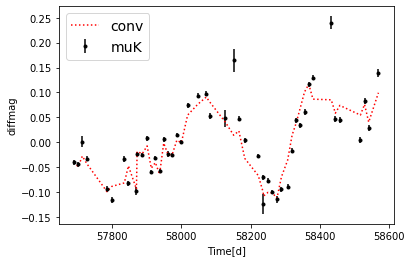

In [52]:
    tau=np.linspace(1.0,100.0,ntau)
    sigma_DT=0.189
    m_DT=59.725
    theta_DT=45.553
    
    #Accretion Disk paramters
    Jsigma_AD=1.567
    Jm_AD=35.840
    Jtheta_AD=-3.853
    
    #BB and power law parameters
    T=1785.800
    K_0=2.459
    index=0.031
    
    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm NEED DATASHEET
    Jwav=1250.0 

    #Define constants 
    wav_0 = 1000.0#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    where_are_NaNs1 = np.isnan(lognorm_DT)
    lognorm_DT[where_are_NaNs1] = 0.0
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*T)
    JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((np.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
    where_are_NaNs2 = np.isnan(Jlognorm_AD)
    Jlognorm_AD[where_are_NaNs2] = 0.0
    JPsi_AD = Jpowr*Jlognorm_AD

    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    
    #The convolutions
    #filter needs to be odd so tau is odd
    Jconvol=np.convolve(mu[0:len(XJ)],Jtransfer,'same')
    
plt.errorbar(XJ, yJ, yerr=yJerr, fmt=".k", capsize=0, label='muK')
#plt.errorbar(XJ, Jconvol, yerr=sd[0:len(XJ)], fmt=".r", capsize=0, label='conv')
plt.plot(XJ, Jconvol, ":r", label="conv")
plt.legend(fontsize=14)
plt.xlabel("Time[d]")
plt.ylabel("diffmag");

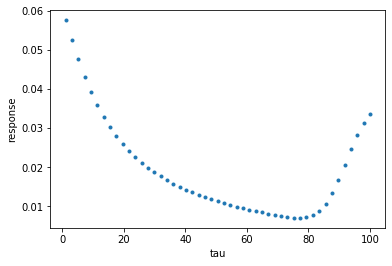

In [62]:
plt.plot(tau,Jtransfer,'.')
plt.xlabel('tau')
plt.ylabel('response');